In [216]:
#Import

#Imputation
from sklearn.impute import SimpleImputer

#Generic
import numpy as np,pandas as pd, matplotlib.pyplot as plt, seaborn as sns, joblib
from matplotlib.ticker import FormatStrFormatter

#Statistics
from scipy.stats import zscore

#Encoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

#Scaler
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#Skewness
from sklearn.preprocessing import PowerTransformer

#Train Test Split
from sklearn.model_selection import train_test_split

#Resample
from sklearn.utils import resample

#Feature Selection
from sklearn.feature_selection import SelectKBest,chi2,f_classif, VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Decomposition
from sklearn.decomposition import PCA

#Cross Validation
from sklearn.model_selection import cross_val_score

#Hypertune Parameters
from sklearn.model_selection import GridSearchCV

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

#Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor

#Classification Metrics
from sklearn.metrics import classification_report,confusion_matrix,f1_score,accuracy_score,recall_score,precision_score
from sklearn.metrics import auc,roc_curve

#Regression Metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score, 

In [49]:
#Import data
df=pd.read_csv('Data file.csv')

In [50]:
#Check head
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [51]:
#Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [52]:
#Check null values
s=df.isna().sum().sort_values(ascending=False)

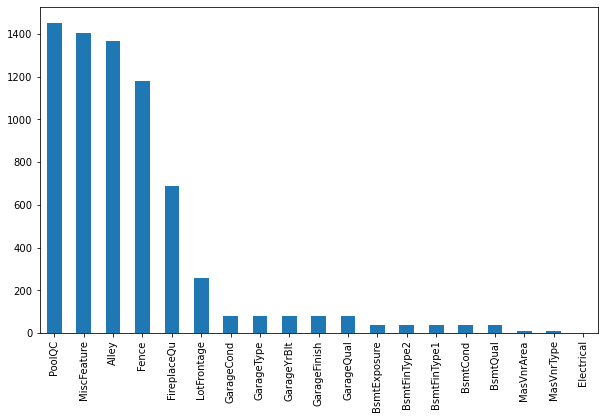

In [53]:
plt.figure(figsize=(10,6))
s_na=s.where(s>0).dropna()
s_na.plot(kind='bar')
plt.show()

In [54]:
#Check percent of null values
s_na/1460*100
#Columns with null values more than 60-70% can be discarded directly as imputing values will lead to miscomputation
#in learning of model in respect to real world data

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

In [55]:
#From the above outcome drop first four columns which have more than 60-70% of missing values
df=df.drop(['PoolQC','MiscFeature','Alley','Fence'],axis=1)

In [56]:
#From the rest of the variables which has null values FireplaceQu has most number of null values
#Hence check value count of FireplaceQu so that we can make a decision for choosing imputation method

df['FireplaceQu'].value_counts()

#Since value Gd and TA have almost equal number of counts we will not be able to use mode/most frequent to impute
#missing data. Hence, we will assign another category (GT) to all the missing values since it comprises of 47%

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [57]:
#Impute GT to null values. We are using random naming convention GT as NA can be reffered as null values 
#by the pandas library
df['FireplaceQu']=df['FireplaceQu'].apply(lambda x:'GT' if pd.isna(x) else x)

In [58]:
#The next variable with most missing null values is LotFrontage
df['LotFrontage'].describe()
#Looking at the stats of the data the mean much is larger then the standard deviation and hence we can use
#mean to impute the missing values in this column

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [59]:
#Impute mean for LotFrontage column
si=SimpleImputer(strategy='mean')
df['LotFrontage']=si.fit_transform(df['LotFrontage'].values.reshape(-1,1))

In [60]:
#Impute most frequent for GarageCond column
sm=SimpleImputer(strategy='most_frequent')
df['GarageCond']=sm.fit_transform(df['GarageCond'].values.reshape(-1,1))

In [61]:
#Impute most frequent for GarageType column
df['GarageType']=sm.fit_transform(df['GarageType'].values.reshape(-1,1))

In [62]:
#Impute mean for GarageYrBlt column
df['GarageYrBlt']=si.fit_transform(df['GarageYrBlt'].values.reshape(-1,1))

In [63]:
#Impute most frequent for GarageType column
df['GarageFinish']=sm.fit_transform(df['GarageFinish'].values.reshape(-1,1))

In [64]:
#Impute most frequent for GarageQual column
df['GarageQual']=sm.fit_transform(df['GarageQual'].values.reshape(-1,1))

In [65]:
#Impute most frequent for BsmtExposure column
df['BsmtExposure']=sm.fit_transform(df['BsmtExposure'].values.reshape(-1,1))

In [66]:
#Impute most frequent for BsmtFinType2 column
df['BsmtFinType2']=sm.fit_transform(df['BsmtFinType2'].values.reshape(-1,1))

In [67]:
#Impute most frequent for BsmtFinType1 column
df['BsmtFinType1']=sm.fit_transform(df['BsmtFinType1'].values.reshape(-1,1))

In [68]:
#Impute most frequent for BsmtCond column
df['BsmtCond']=sm.fit_transform(df['BsmtCond'].values.reshape(-1,1))

In [69]:
#Impute most frequent for BsmtQual column
df['BsmtQual']=sm.fit_transform(df['BsmtQual'].values.reshape(-1,1))

In [70]:
#Impute mean for MasVnrArea column
df['MasVnrArea']=si.fit_transform(df['MasVnrArea'].values.reshape(-1,1))

In [71]:
#Impute most frequent for MasVnrType column
df['MasVnrType']=sm.fit_transform(df['MasVnrType'].values.reshape(-1,1))

In [72]:
#Impute most frequent for Electrical column
df['Electrical']=sm.fit_transform(df['Electrical'].values.reshape(-1,1))

In [73]:
#Check that there are no variables remaining with null columns
sum(df.isna().sum()!=0)

0

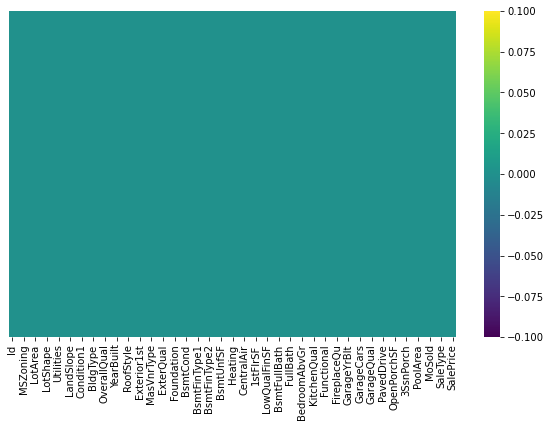

In [74]:
#Plot a heatmap to check that there are no variables with null values
plt.figure(figsize=(10,6))
sns.heatmap(df.isna(),yticklabels=False,cmap='viridis')
plt.show()

In [75]:
#Check stats of data specifically for SalePrice
df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    22.024023    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    60.000000    7553.500000     5.000000   
50%     730.500000    50.000000    70.049958    9478.500000     6.000000   
75%    1095.250000    70.000000    79.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   180.569112   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   164.250000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [76]:
#Drop ID Column as it will not help model to train well because all the values in that column are unique
df=df.drop('Id',axis=1)

In [77]:
#Encode object datatypes with LabelEncoding/OneHotEncoding/getdummies
#For variables which are of object dtypes and which consist more than 2 unique values we will either use
#OneHotEncoding or getdummies

df.select_dtypes('object').columns

#We will take each column and check its value_count

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [78]:
#Check value count of the column
df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [79]:
#Use get_dummies to encode the values for object dtype
df=pd.concat([pd.get_dummies(df['MSZoning']),df.drop('MSZoning',axis=1)],axis=1)

In [80]:
#Check value count of the column
df['Street'].value_counts()
#As we can see that the values in this column is highly skewed we will prefer to delete this column as all the
#fields with similar values will not help to train the model

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [81]:
#Drop the column
df=df.drop('Street',axis=1)

In [82]:
#Check value count of the column
df['LotShape'].value_counts()
#If we use LabelEncode with all the columns then the major issue is the Encoding will be done in single column
#as 1,2,3,etc. which will be considered as rank or order instead of specific value
#However going outside the system and analyzing domain specific knowledge of this column, LotShape is regarding
#the regularity of the house and majority of the values are for Regular Houses hence, we can consider using
#LabelEncoder for this column as irregularity increases the price of houses will be higher

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

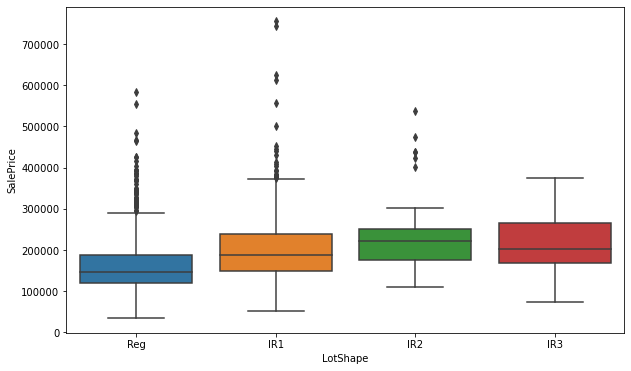

In [83]:
#The description mentioned above can be proved by below boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='LotShape',y='SalePrice',data=df)
plt.show()
#IR3 has maximum SalePrice while it decrease as we move from right column to left

In [84]:
#Encode the values with LabelEncoder
le=LabelEncoder()
df['LotShape']=le.fit_transform(df['LotShape'])

In [85]:
#Check value count of the column
df['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

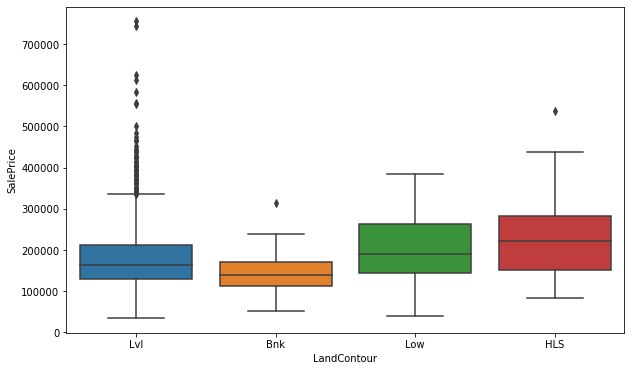

In [86]:
#By plotting the boxplot we can see that it is also similar to LotShape hence we can LabelEncode
plt.figure(figsize=(10,6))
sns.boxplot(x='LandContour',y='SalePrice',data=df)
plt.show()

In [87]:
#Encode the values with LabelEncoder
df['LandContour']=le.fit_transform(df['LandContour'])

In [88]:
#Check value count of the column
df['Utilities'].value_counts()
#As we can see that there is only one field with different value except AllPub
#Hence we can move forward with deleting this entire column

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [89]:
#Drop columns
df=df.drop('Utilities',axis=1)

In [90]:
#Check value count of the column
df['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

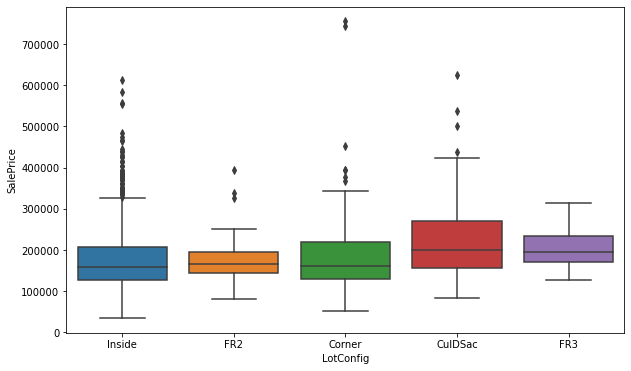

In [91]:
#We will use boxplot to get more insights on the data
plt.figure(figsize=(10,6))
sns.boxplot(x='LotConfig',y='SalePrice',data=df)
plt.show()

In [92]:
#Since the type of data is nominal and the carinality is less then 15 and we might or might not use 
#Decision Tree based models we will use OneHotEncoder/get_dummies. We can also use TargetEncoder but it might lead to 
#overfitting considering the data that we have.

#Use get_dummies to encode the values for object dtype
df=pd.concat([pd.get_dummies(df['LotConfig'],prefix='LotConfig'),df.drop('LotConfig',axis=1)],axis=1)

In [93]:
#Check value count of the column
df['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

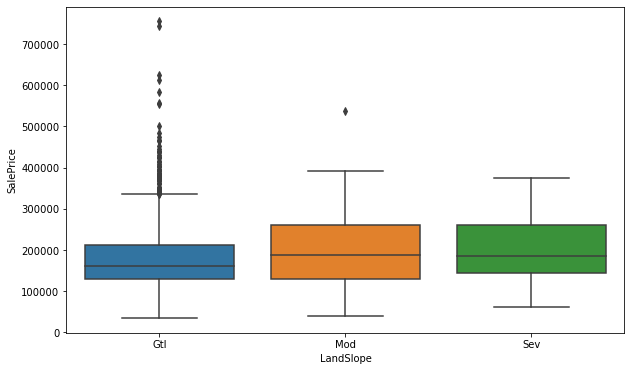

In [94]:
#We will use boxplot to get more insights on the data
plt.figure(figsize=(10,6))
sns.boxplot(x='LandSlope',y='SalePrice',data=df)
plt.show()

In [95]:
#The data is not ordinal directly from the values but from the above box plot we can see that the price is 
#increasing along with the slope hecne we will use LabelEncoder/OrdinalEncoder
df['LandSlope']=le.fit_transform(df['LandSlope'])

In [96]:
#Check value count of the column
df['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [97]:
#If we use OneHotEncoder for this type of sparse data then we will have to face curse of High Dimesnionality 
#hence we would use TargetEncoder

te=TargetEncoder()
df['Neighborhood_Enc']=te.fit_transform(df['Neighborhood'],df['SalePrice'])

#Mark this in notes and remove Neighborhood from X. We are keeping Neighborhood in our dataset so that we can
#change encoding technique is needed

/Users/prinjaldave/Documents/Anaconda_Packages/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [98]:
#Check value count of the column
df['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [99]:
#If we use OneHotEncoder for this type of sparse data then we will have to face curse of High Dimesnionality 
#hence we would use TargetEncoder

te=TargetEncoder()
df['Condition1_Enc']=te.fit_transform(df['Condition1'],df['SalePrice'])

#Mark this in notes and remove Condition1 from X. We are keeping Condition1 in our dataset so that we can
#change encoding technique is needed

/Users/prinjaldave/Documents/Anaconda_Packages/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [100]:
df['Condition2'].value_counts()
#As the data is highly skewed hence we can directly delete this column

Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
RRAe         1
RRAn         1
PosA         1
Name: Condition2, dtype: int64

In [101]:
#Drop Condition2 column
df=df.drop('Condition2',axis=1)

In [102]:
#Check value counts for this column
df['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [103]:
#If we use OneHotEncoder for this type of sparse data then we will have to face curse of High Dimesnionality 
#hence we would use TargetEncoder

te=TargetEncoder()
df['BldgType_Enc']=te.fit_transform(df['BldgType'],df['SalePrice'])

#Mark this in notes and remove BldgType from X. We are keeping BldgType in our dataset so that we can
#change encoding technique is needed

/Users/prinjaldave/Documents/Anaconda_Packages/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [104]:
#Check value counts for this column
df['HouseStyle'].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [105]:
#If we use OneHotEncoder for this type of sparse data then we will have to face curse of High Dimesnionality 
#hence we would use TargetEncoder

te=TargetEncoder()
df['HouseStyle_Enc']=te.fit_transform(df['BldgType'],df['SalePrice'])

#Mark this in notes and remove HouseStyle from X. We are keeping HouseStyle in our dataset so that we can
#change encoding technique is needed

/Users/prinjaldave/Documents/Anaconda_Packages/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [106]:
#Check value counts for this column
df['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [107]:
#If we use OneHotEncoder for this type of sparse data then we will have to face curse of High Dimesnionality 
#hence we would use TargetEncoder

te=TargetEncoder()
df['RoofStyle_Enc']=te.fit_transform(df['RoofStyle'],df['SalePrice'])

#Mark this in notes and remove RoofStyle from X. We are keeping RoofStyle in our dataset so that we can
#change encoding technique is needed

/Users/prinjaldave/Documents/Anaconda_Packages/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [108]:
#Check value counts for this column
df['RoofMatl'].value_counts()
#As the data is highly skewed we can directly delete the column

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Metal         1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64

In [109]:
#Drop the RoofMatl column
df=df.drop('RoofMatl',axis=1)

In [110]:
#Check value counts for this column
df['Exterior1st'].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
CBlock       1
AsphShn      1
ImStucc      1
Name: Exterior1st, dtype: int64

In [114]:
#Create get_dummies
Exerior1st=pd.get_dummies(df['Exterior1st'],prefix='Exterior1st')[['Exterior1st_VinylSd','Exterior1st_HdBoard','Exterior1st_MetalSd','Exterior1st_Plywood','Exterior1st_CemntBd']]

In [115]:
#Concat get_dummies with main frame
df=pd.concat([df.drop('Exterior1st',axis=1),Exerior1st],axis=1)

In [116]:
#Check value counts
df['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [117]:
#Create get_dummies
Exterior2nd=pd.get_dummies(df['Exterior2nd'],prefix='Exterior2nd')[['Exterior2nd_VinylSd','Exterior2nd_HdBoard','Exterior2nd_MetalSd','Exterior2nd_Plywood','Exterior2nd_CmentBd']]

In [118]:
#Concat get_dummies with main frame
df=pd.concat([df.drop('Exterior2nd',axis=1),Exterior2nd],axis=1)

In [119]:
#Check value counts
df['MasVnrType'].value_counts()

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [121]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['MasVnrType'],prefix='MasVnrType').drop('MasVnrType_BrkCmn',axis=1),df.drop('MasVnrType',axis=1)],axis=1)

In [122]:
#Check value counts
df['ExterQual'].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [124]:
#Create get_dummies
ExteriorQual=pd.get_dummies(df['ExterQual'],prefix='ExterQual')[['ExterQual_TA','ExterQual_Gd']]

In [125]:
#Concat get_dummies with main frame
df=pd.concat([df.drop('ExterQual',axis=1),ExteriorQual],axis=1)

In [126]:
#Check value counts
df['ExterCond'].value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [127]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['ExterCond'],prefix='ExterCond').drop(['ExterCond_Fa','ExterCond_Ex','ExterCond_Po'],axis=1),df.drop('ExterCond',axis=1)],axis=1)

In [128]:
#Encode object datatypes with LabelEncoding/OneHotEncoding/getdummies
#For variables which are of object dtypes and which consist more than 2 unique values we will either use
#OneHotEncoding or getdummies

df.select_dtypes('object').columns

#We will take each column and check its value_count

Index(['Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [129]:
#Check value counts
df['Foundation'].value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [130]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['Foundation'],prefix='Foundation').drop(['Foundation_Slab','Foundation_Stone','Foundation_Wood'],axis=1),df.drop('Foundation',axis=1)],axis=1)

In [131]:
#Check value counts
df['BsmtQual'].value_counts()

TA    686
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [132]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['BsmtQual'],prefix='BsmtQual').drop(['BsmtQual_Fa'],axis=1),df.drop('BsmtQual',axis=1)],axis=1)

In [133]:
#Check value counts
df['BsmtCond'].value_counts()
#As we can see the data is highly skewed which is more than 85%. Hence we will discard the column.

TA    1348
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [134]:
df=df.drop('BsmtCond',axis=1)

In [135]:
#Check value counts
df['BsmtExposure'].value_counts()

No    991
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [136]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['BsmtExposure'],prefix='BsmtExposure'),df.drop('BsmtExposure',axis=1)],axis=1)

In [137]:
#Check value counts
df['BsmtFinType1'].value_counts()

Unf    467
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [138]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['BsmtFinType1'],prefix='BsmtFinType1'),df.drop('BsmtFinType1',axis=1)],axis=1)

In [139]:
#Check value counts
df['BsmtFinType2'].value_counts()
#As we can see the data is highly skewed which is more than 85%. Hence we will discard the column.

Unf    1294
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [140]:
#Drop the column
df=df.drop('BsmtFinType2',axis=1)

In [141]:
#Check value counts
df['Heating'].value_counts()
#As we can see the data is highly skewed which is more than 85%. Hence we will discard the column.

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [142]:
#Drop the column
df=df.drop('Heating',axis=1)

In [143]:
#Check value counts
df['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

In [144]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['HeatingQC'],prefix='HeatingQC').drop(['HeatingQC_Po','HeatingQC_Fa'],axis=1),df.drop('HeatingQC',axis=1)],axis=1)

In [145]:
#Encode object datatypes with LabelEncoding/OneHotEncoding/getdummies
#For variables which are of object dtypes and which consist more than 2 unique values we will either use
#OneHotEncoding or getdummies

df.select_dtypes('object').columns

#We will take each column and check its value_count

Index(['Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [146]:
#Check value counts
df['CentralAir'].value_counts()
#As we can see the data is highly skewed which is more than 85%. Hence we will discard the column.

Y    1365
N      95
Name: CentralAir, dtype: int64

In [147]:
#Drop the column
df=df.drop('CentralAir',axis=1)

In [148]:
#Check value counts
df['Electrical'].value_counts()
#As we can see the data is highly skewed which is more than 85%. Hence we will discard the column.

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [149]:
#Drop the column
df=df.drop('Electrical',axis=1)

In [150]:
#Check value counts
df['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [151]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['KitchenQual'],prefix='KitchenQual').drop('KitchenQual_Fa',axis=1),df.drop('KitchenQual',axis=1)],axis=1)

In [152]:
#Check value counts
df['Functional'].value_counts()
#As we can see the data is highly skewed which is more than 85%. Hence we will discard the column.

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [153]:
#Drop the column
df=df.drop('Functional',axis=1)

In [154]:
#Check value counts
df['FireplaceQu'].value_counts()

GT    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [155]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['FireplaceQu'],prefix='FireplaceQu').drop(['FireplaceQu_Fa','FireplaceQu_Ex','FireplaceQu_Po'],axis=1),df.drop('FireplaceQu',axis=1)],axis=1)

In [156]:
#Check value counts
df['GarageType'].value_counts()

Attchd     951
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [157]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['GarageType'],prefix='GarageType').drop(['GarageType_Basment','GarageType_CarPort','GarageType_2Types'],axis=1),df.drop('GarageType',axis=1)],axis=1)

In [158]:
#Check value counts
df['GarageFinish'].value_counts()

Unf    686
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [159]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['GarageFinish'],prefix='GarageFinish'),df.drop('GarageFinish',axis=1)],axis=1)

In [160]:
#Check value counts
df['GarageQual'].value_counts()
#As we can see the data is highly skewed which is more than 85%. Hence we will discard the column.

TA    1392
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

In [161]:
#Drop the column
df=df.drop('GarageQual',axis=1)

In [162]:
#Check value counts
df['GarageCond'].value_counts()
#As we can see the data is highly skewed which is more than 85%. Hence we will discard the column.

TA    1407
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [163]:
#Drop the column
df=df.drop('GarageCond',axis=1)

In [164]:
#Check value counts
df['PavedDrive'].value_counts()
#As we can see the data is highly skewed which is more than 85%. Hence we will discard the column.

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [165]:
#Drop the column
df=df.drop('PavedDrive',axis=1)

In [166]:
#Check value counts
df['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [167]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['SaleType'],prefix='SaleType').drop(['SaleType_ConLD','SaleType_ConLI','SaleType_ConLw','SaleType_CWD','SaleType_Oth','SaleType_Con'],axis=1),df.drop('SaleType',axis=1)],axis=1)

In [168]:
#Check value counts
df['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [169]:
#Concat dummies with main frame
df=pd.concat([pd.get_dummies(df['SaleCondition'],prefix='SaleCondition').drop(['SaleCondition_Family','SaleCondition_Alloca','SaleCondition_AdjLand'],axis=1),df.drop('SaleCondition',axis=1)],axis=1)

In [170]:
#All the variables are labelencoded
#Next step is to remove outliers, scale the data and run raw data with a model to determine the performance

In [171]:
#Check object columns which we have to discard for X
df.select_dtypes('object').columns

Index(['Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle'], dtype='object')

In [172]:
#Compute z score for removing outliers
z=zscore(df.drop(['Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle'],axis=1))

In [173]:
#Shape of original DataFrame
df.shape

(1460, 114)

In [174]:
#Remove outliers from the data
#df=df[(z<3).all(axis=1)]
df=df[(z<5).all(axis=1)]

In [175]:
#Shape of new DataFrame
df.shape

(1254, 114)

In [344]:
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice           1.000000
OverallQual         0.805470
Neighborhood_Enc    0.761267
GrLivArea           0.736937
GarageCars          0.677199
                      ...   
FireplaceQu_GT     -0.464514
BsmtQual_TA        -0.521925
KitchenQual_TA     -0.539452
GarageFinish_Unf   -0.544584
ExterQual_TA       -0.620342
Name: SalePrice, Length: 103, dtype: float64

In [ ]:
#Drop the column
df=df.drop('FR2',axis=1)

In [180]:
#Check shape
df.shape

(1254, 114)

In [182]:
#We will drop all the columns which has one unique value
for x in df.columns:
    if df[x].nunique()==1:
        df=df.drop(x,axis=1)

In [183]:
#Check shape
df.shape

(1254, 108)

In [488]:
#Remove skewness from the dataset
pt=PowerTransformer()
for x in df.columns.drop(['SalePrice','Neighborhood','Condition1','BldgType','HouseStyle','RoofStyle']):
    if abs(df[x].skew())>0.55:
        df[x]=pt.fit_transform(df[x].values.reshape(-1,1))

In [267]:
corr=pd.DataFrame(df.corr()['SalePrice'].sort_values(ascending=False).drop('SalePrice'))
high_corr=corr[corr['SalePrice']>0.55].index
high_corr

Index(['OverallQual', 'Neighborhood_Enc', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt',
       'TotRmsAbvGrd', 'BsmtQual_Ex'],
      dtype='object')

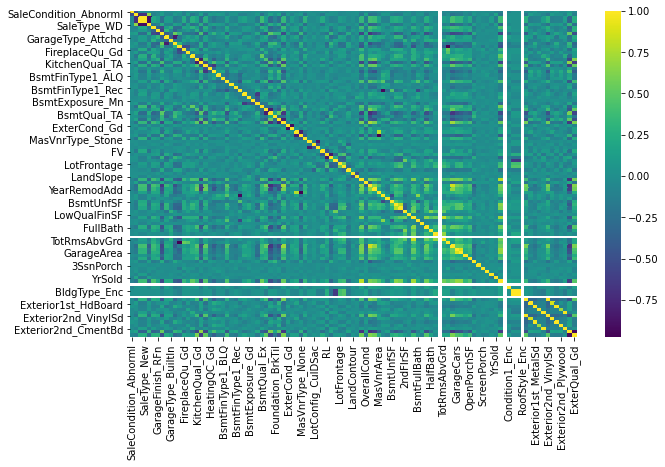

In [495]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),cmap='viridis')
plt.show()

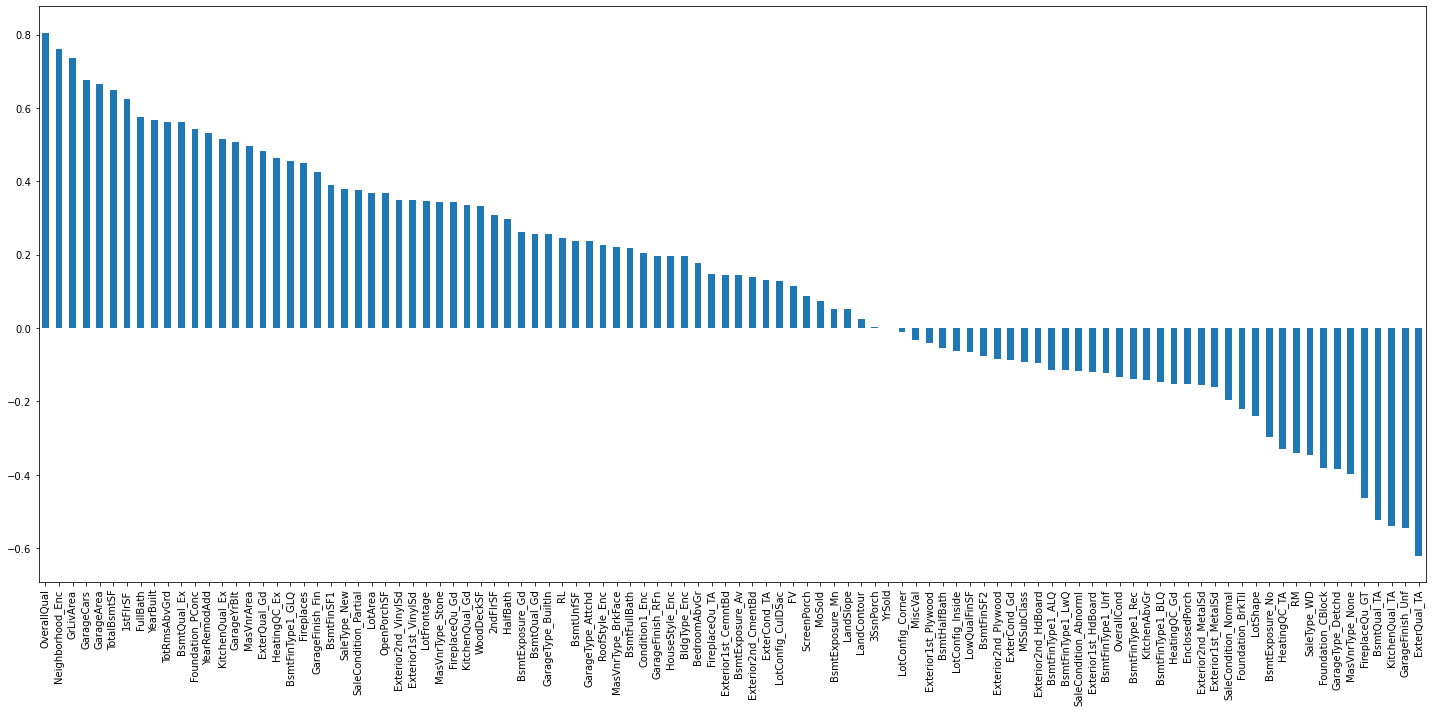

In [185]:
plt.figure(figsize=(20,10))
df.corr()['SalePrice'].sort_values(ascending=False).drop('SalePrice').plot(kind='bar')
plt.tight_layout()
plt.show()

In [445]:
#Divide the dataframe into features and target
#We will drop off some columns which are already converted into dummy varibales
#Also we have dropped OverallQual columm which might overfit the model as its correlation is more than 1
X=df.drop(['Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle','SalePrice'],axis=1)
y=df['SalePrice']

In [446]:
cols=X.columns

In [447]:
#Scale the data
scale=MinMaxScaler()
X=scale.fit_transform(X)

In [448]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=103)

In [449]:
#Train the data
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [450]:
#Predict data
predict_lr=lr.predict(X_test)

In [451]:
#Since cross validation with LinearRegression is giving a negative score we will use Ensemble techniques
cross_val_score(lr,X_train,y_train).mean()

-7.705288271527705e+20

In [452]:
mse=mean_squared_error(y_test,predict_lr)
rmse=np.sqrt(mse)
r2=r2_score(y_test,predict_lr)
print(rmse)
print(r2)

21266.273952180218
0.9188975256280981


In [489]:
#Train the data
rf=RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

In [490]:
#Predict data
predict_rf=rf.predict(X_test)

In [456]:
#Train the data
bgr=BaggingRegressor()
bgr.fit(X_train,y_train)

BaggingRegressor()

In [457]:
#Predict data
predict_bgr=bgr.predict(X_test)

In [458]:
mse=mean_squared_error(y_test,predict_bgr)
rmse=np.sqrt(mse)
print
print(rmse)
print(r2_score(y_test,predict_bgr))

24294.336223790215
0.8941571875509026


In [492]:
cross_val_score(RandomForestRegressor(),X_train,y_train,cv=5).mean()

0.8723648642952113

In [493]:
adj_r2=1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
adj_r2

0.9050955668060658

In [461]:
feat_imp=pd.DataFrame(list(zip(cols,rf.feature_importances_)),columns=['Features','Importance'])

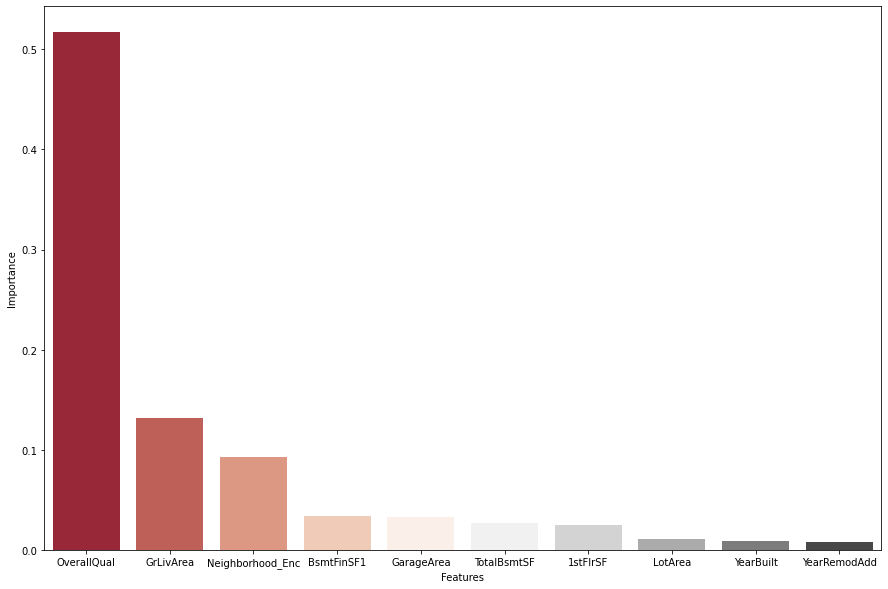

In [462]:
feat_imp=feat_imp.sort_values(by='Importance',ascending=False).head(10)
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.barplot(x='Features',y='Importance',data=feat_imp,palette='RdGy')
plt.show()

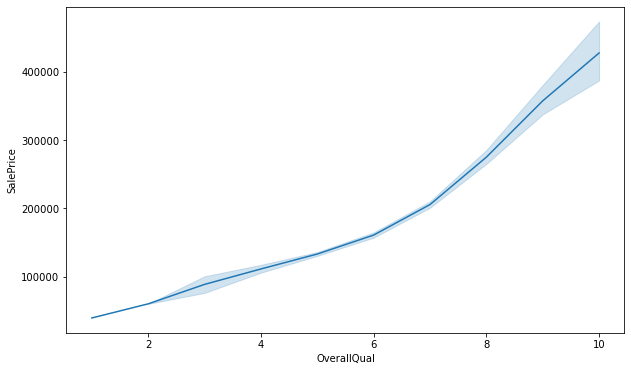

In [463]:
#We will use boxplot to get more insights on the data
plt.figure(figsize=(10,6))
sns.lineplot(x='OverallQual',y='SalePrice',data=df)
plt.show()

In [464]:
#As seen above OverallQual is the most important feature in predicting the prices
#With increase in OverallQual the SalePrice increases

In [465]:
joblib.dump(rf,'Housing Price RF.obj')

['Housing Price RF.obj']